In [93]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from pathlib import Path

import textstat
import nltk
from collections import Counter
from language_tool_python import LanguageTool

import spacy
import torch
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaModel, RobertaTokenizer, RobertaForSequenceClassification, T5Tokenizer, T5ForConditionalGeneration

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from xgboost import XGBRegressor

### Load Data

In [112]:
local_dir = Path(os.getcwd())
kaggle_df = Path('/kaggle/input')

In [113]:
train_df = pd.read_csv(local_dir / 'commonlit-evaluate-student-summaries' / 'summaries_train.csv')
train_prompts_df = pd.read_csv(local_dir / 'commonlit-evaluate-student-summaries' / 'prompts_train.csv')

## Create Heuristic Features

In [114]:
def create_text_features(df):
    # Define the transition phrases
    transition_phrases_dict = {
        'To Add': ['and', 'again', 'and then', 'besides', 'equally important', 'finally', 'further', 'furthermore', 'nor', 'too', 'next', 'lastly', 'what\'s more', 'moreover', 'in addition', 'first', 'second', 'etc.'],
        'To Compare': ['whereas', 'but', 'yet', 'on the other hand', 'however', 'nevertheless', 'on the contrary', 'by comparison', 'where', 'compared to', 'up against', 'balanced against', 'vis a vis', 'but', 'although', 'conversely', 'meanwhile', 'after all', 'in contrast', 'although this may be true'],
        'To Prove': ['because', 'for', 'since', 'for the same reason', 'obviously', 'evidently', 'furthermore', 'moreover', 'besides', 'indeed', 'in fact', 'in addition', 'in any case', 'that is'],
        'To Show Exception': ['yet', 'still', 'however', 'nevertheless', 'in spite of', 'despite', 'of course', 'once in a while', 'sometimes'],
        'To Show Time': ['immediately', 'thereafter', 'soon', 'after a few hours', 'finally', 'then', 'later', 'previously', 'formerly', 'first', 'second', 'etc.', 'next', 'and then'],
        'To Repeat': ['in brief', 'as I have said', 'as I have noted', 'as has been noted'],
        'To Emphasize': ['definitely', 'extremely', 'obviously', 'in fact', 'indeed', 'in any case', 'absolutely', 'positively', 'naturally', 'surprisingly', 'always', 'forever', 'perennially', 'eternally', 'never', 'emphatically', 'unquestionably', 'without a doubt', 'certainly', 'undeniably', 'without reservation'],
        'To Show Sequence': ['first', 'second', 'third', 'and so forth', 'next', 'then', 'following this', 'at this time', 'now', 'at this point', 'after', 'afterward', 'subsequently', 'finally', 'consequently', 'previously', 'before this', 'simultaneously', 'concurrently', 'thus', 'therefore', 'hence', 'next', 'and then', 'soon'],
        'To Give an Example': ['for example', 'for instance', 'in this case', 'in another case', 'on this occasion', 'in this situation', 'take the case of', 'to demonstrate', 'to illustrate', 'as an illustration'],
        'To Summarize or Conclude': ['in brief', 'on the whole', 'summing up', 'to conclude', 'in conclusion', 'as I have shown', 'as I have said', 'hence', 'therefore', 'accordingly', 'thus', 'as a result', 'consequently']
    }
    
    # Precompile the regular expressions
    transition_phrases_dict = {
        name: [re.compile(r'\b' + re.escape(phrase) + r'\b') for phrase in phrases] for name, phrases in transition_phrases_dict.items()
    }

    for i, row in df.iterrows():
        # Tokenize the text
        text_words = nltk.word_tokenize(row['text'].lower())
        text_words = [word for word in text_words if word.isalpha()]
        text_sentences = nltk.sent_tokenize(row['text'])

        # Compute word count statistics
        word_counts = Counter(text_words)
        
        # Calculate the length metrics
        length_metrics = {
            'Text Length': len(row['text']),
            'Text Word Count': len(text_words),
            'Text Sentence Count': len(text_sentences),
            'Words Over 6': len([word for word in text_words if len(word) > 6]),
            'Words Over 8': len([word for word in text_words if len(word) > 8]),
            'Words Over 10': len([word for word in text_words if len(word) > 10]),
            'Unique Words': len(np.unique(text_words))
        }
        
        # Calculate the ratios
        ratio_metrics = {
            'Word Count to Length Ratio': length_metrics['Text Word Count'] / length_metrics['Text Length'],
            'Word Count to Length Ratio': length_metrics['Unique Words'] / length_metrics['Text Length'],
            'Unique Word Density': length_metrics['Unique Words'] / length_metrics['Text Word Count'],
            'Words Per Sentence': length_metrics['Text Word Count'] / length_metrics['Text Sentence Count'],
            'Average Sentence Length': length_metrics['Text Length'] / length_metrics['Text Sentence Count'],
            'Words Over 6 Ratio': length_metrics['Words Over 6'] / length_metrics['Text Word Count'],
            'Words Over 8 Ratio': length_metrics['Words Over 8'] / length_metrics['Text Word Count'],
            'Words Over 10 Ratio': length_metrics['Words Over 10'] / length_metrics['Text Word Count'],
        }
        
        # Calculate the readability metrics
        readability_metrics = {
            'Flesch Reading Ease': textstat.flesch_reading_ease(row['text']),
            'Flesch Kincaid Grade': textstat.flesch_kincaid_grade(row['text']),
            'Smog Index': textstat.smog_index(row['text']),
            'Coleman Liau Index': textstat.coleman_liau_index(row['text']),
            'Automated Readability Index': textstat.automated_readability_index(row['text']),
            'Dale Chall Readability Score': textstat.dale_chall_readability_score(row['text']),
            'Difficult Words': textstat.difficult_words(row['text']),
            'Linsear Write Formula': textstat.linsear_write_formula(row['text']),
            'Gunning Fog': textstat.gunning_fog(row['text']),
            'Text Standard': textstat.text_standard(row['text'], float_output = True),
            'Fernandez Huerta': textstat.fernandez_huerta(row['text']),
            'Szigriszt Pazos': textstat.szigriszt_pazos(row['text']),
            'Gutierrez Polini': textstat.gutierrez_polini(row['text']),
            'Crawford': textstat.crawford(row['text']),
            'Gulpease Index': textstat.gulpease_index(row['text']),
            'Osman': textstat.osman(row['text']),
        }

        # Initialize the dictionary to store the counts of transition phrases
        transition_phrases_counts = {name + ' Transition': 0 for name in transition_phrases_dict}

        # Count the occurrences of each transition phrase
        for name, patterns in transition_phrases_dict.items():
            for pattern in patterns:
                transition_phrases_counts[name + ' Transition'] += len(pattern.findall(row['text'].lower()))
        

        # Calculate the sum of transition phrases and unique transitions
        transition_phrases_counts['Transitions Sum'] = sum(transition_phrases_counts.values())
        transition_phrases_counts['Unique Transitions'] = len([value for value in transition_phrases_counts.values() if value > 0]) - 1
        
        # Add the new metrics to the DataFrame
        for metric_name, metric_value in {**length_metrics, **ratio_metrics, **readability_metrics, **transition_phrases_counts}.items():
            df.at[i, metric_name] = metric_value
            
    return df


In [115]:
def create_grammar_features(df):
    grammar_tool = LanguageTool('en-US')
    # Pre-fill DataFrame
    grammar_cols = [
        'TYPOS', 'TYPOGRAPHY', 'CASING', 'PUNCTUATION', 'GRAMMAR',
        'REDUNDANCY', 'STYLE', 'CONFUSED_WORDS', 'OTHER',
        'TOTAL_ERRORS', 'MIN_ERROR_LOCATION', 'MAX_ERROR_LOCATION', 'AVERAGE_ERROR_LOCATION'
    ]
    df_len = len(df)
    df_width = len(grammar_cols)
    grammar_df = pd.DataFrame(
        data = np.zeros((df_len, df_width), dtype=float),
        columns = grammar_cols,
        index = df.index
    )
    
    for idx, text in df['text'].items():
        matches = grammar_tool.check(text)
        error_locations = []
        grammar_df.loc[idx, 'TOTAL_ERRORS'] = len(matches)
        for match in matches:
            if match.category in grammar_cols:
                grammar_df.loc[idx, match.category] += 1
            else:
                grammar_df.loc[idx, 'OTHER'] += 1
            
            error_locations.append(match.offset)
        
        if len(error_locations) > 0:
            grammar_df.at[idx, 'MIN_ERROR_LOCATION'] = min(error_locations)
            grammar_df.at[idx, 'MAX_ERROR_LOCATION'] = max(error_locations)
            grammar_df.at[idx, 'AVERAGE_ERROR_LOCATION'] = np.mean(error_locations)
    
    # Beautify column names
    grammar_df.columns = grammar_df.columns.str.title().str.replace('_', ' ')
    return pd.concat([df, grammar_df], axis = 1)

In [116]:
train_df = create_text_features(train_df)
train_df = create_grammar_features(train_df)

## RoBERTa for Content Scoring

In [96]:
model_name = 't5-base'
model = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name, model_max_length = 512)

In [97]:
def summarize_text(prompt, text, max_length=128):
    input_text = 'summarize: ' + prompt + text
    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)
    summary_ids = model.generate(input_ids, max_length=max_length, length_penalty=5.0, num_beams=5, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [98]:
train_prompts_df['prompt_text_summary'] = np.zeros(len(train_prompts_df), dtype=object)
for i, row in train_prompts_df.iterrows():
    train_prompts_df.loc[i, 'prompt_text_summary'] = summarize_text(row['prompt_question'], row['prompt_text'])

In [137]:
train_df = train_df.merge(train_prompts_df, on = 'prompt_id', how = 'inner')

In [138]:
training_df = train_df[train_df['prompt_title'] != 'On Tragedy']
validation_df = train_df[train_df['prompt_title'] == 'On Tragedy']

In [19]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_validation_loss(model, val_loader, device):
    model.eval()  # set the model to evaluation mode
    total_val_loss = 0
    
    with torch.no_grad():
        for val_batch in val_loader:
            input_ids, attention_mask, labels = val_batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    model.train()  # set the model back to training mode
    return avg_val_loss


In [111]:
for score in ['wording']:

    print(f'Training model for {score}...')
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)
    
    print('Preparing data...')
    training_prompts = training_df['prompt_text_summary'].to_list()
    training_responses = training_df['text'].to_list()
    training_scores = training_df[score].to_list()

    validation_prompts = validation_df['prompt_text_summary'].to_list()
    validation_responses = validation_df['text'].to_list()
    validation_scores = validation_df[score].to_list()

    train_encodings = tokenizer(training_prompts, training_responses, truncation=True, padding=True, max_length=512, return_tensors='pt')
    train_scores_tensor = torch.tensor(training_scores).unsqueeze(-1).float()
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_scores_tensor)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

    val_encodings = tokenizer(validation_prompts, validation_responses, truncation=True, padding=True, max_length=512, return_tensors='pt')
    val_scores_tensor = torch.tensor(validation_scores).unsqueeze(-1).float()
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_scores_tensor)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    device = torch.device('mps')
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=3e-5)
    
    print('Training model...')
    epochs = 10
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        i = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            i += 1
            if i % 50 == 0:
                print(f'Epoch {epoch + 1}/{epochs} - Batch {i}/{len(train_loader)} - Training Loss: {loss.item():.4f}')
        
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = compute_validation_loss(model, val_loader, device)
        print(f'Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}')
        
    # save model to directory
    model_name = score + '_test_model'
    model.save_pretrained(local_dir / model_name)
    
    print('Evaluating model...')
    model = RobertaForSequenceClassification.from_pretrained(local_dir / model_name, num_labels=1)
    model.to(device)
    model.eval()
    total_val_loss = 0
    predictions = []
    with torch.no_grad():
        for val_batch in val_loader:
            input_ids, attention_mask, labels = val_batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()
            predictions.append(outputs.logits)
            
    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Validation Loss: {avg_val_loss:.4f}')

    predictions = torch.cat(predictions, dim=0).cpu().numpy()
    predictions = predictions.flatten()
    validation_scores = np.array(validation_scores)
    mse = mean_squared_error(validation_scores, predictions)
    print(f'MSE: {mse:.4f}')

    print('Saving predictions...')
    validation_df[score + '_predictions'] = predictions
    validation_df.to_csv(local_dir / 'predictions.csv', index=False)

    print('Done!\n\n')

Training model for wording...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preparing data...


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Training model...
Epoch 1/10 - Batch 50/639 - Training Loss: 0.4633
Epoch 1/10 - Batch 100/639 - Training Loss: 0.5622
Epoch 1/10 - Batch 150/639 - Training Loss: 0.7168
Epoch 1/10 - Batch 200/639 - Training Loss: 0.8816
Epoch 1/10 - Batch 250/639 - Training Loss: 0.2789
Epoch 1/10 - Batch 300/639 - Training Loss: 1.0032
Epoch 1/10 - Batch 350/639 - Training Loss: 0.1571
Epoch 1/10 - Batch 400/639 - Training Loss: 0.2954
Epoch 1/10 - Batch 450/639 - Training Loss: 0.3617
Epoch 1/10 - Batch 500/639 - Training Loss: 0.4249
Epoch 1/10 - Batch 550/639 - Training Loss: 0.5900
Epoch 1/10 - Batch 600/639 - Training Loss: 0.4738
Epoch 1/10 - Training Loss: 0.5743 - Validation Loss: 0.9525
Epoch 2/10 - Batch 50/639 - Training Loss: 0.7330
Epoch 2/10 - Batch 100/639 - Training Loss: 0.5462
Epoch 2/10 - Batch 150/639 - Training Loss: 0.0808
Epoch 2/10 - Batch 200/639 - Training Loss: 0.8598
Epoch 2/10 - Batch 250/639 - Training Loss: 0.1865
Epoch 2/10 - Batch 300/639 - Training Loss: 0.3540
Epoch

In [108]:
predictions.shape

(2057,)

In [109]:
val_scores.shape

(717,)

In [110]:
print('Evaluating model...')
model = RobertaForSequenceClassification.from_pretrained(local_dir / model_name, num_labels=1)
model.to(device)
model.eval()
total_val_loss = 0
predictions = []
with torch.no_grad():
    for val_batch in val_loader:
        input_ids, attention_mask, labels = val_batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss = outputs.loss
        total_val_loss += val_loss.item()
        predictions.append(outputs.logits)
        
avg_val_loss = total_val_loss / len(val_loader)
print(f'Validation Loss: {avg_val_loss:.4f}')

predictions = torch.cat(predictions, dim=0).cpu().numpy()
predictions = predictions.flatten()
validation_scores = np.array(validation_scores)
mse = mean_squared_error(validation_scores, predictions)
print(f'MSE: {mse:.4f}')

print('Saving predictions...')
validation_df[score + '_predictions'] = predictions
validation_df.to_csv(local_dir / 'predictions.csv', index=False)

print('Done!\n\n')

Evaluating model...
Validation Loss: 0.2528
MSE: 0.2535
Saving predictions...
Done!




In [33]:
def compute_validation_loss(model, val_loader, device):
    model.eval()  # set the model to evaluation mode
    total_val_loss = 0
    
    with torch.no_grad():
        for val_batch in val_loader:
            input_ids, attention_mask, labels = val_batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    model.train()  # set the model back to training mode
    return avg_val_loss


In [35]:
device = torch.device('mps')
model.to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)

epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    i = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        i += 1
        if i % 25 == 0:
            print(f'Epoch {epoch + 1}/{epochs} - Batch {i}/{len(train_loader)} - Training Loss: {loss.item():.4f}')
    
    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = compute_validation_loss(model, val_loader, device)
    print(f'Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}')

Epoch 1/3 - Batch 25/806 - Training Loss: 0.2370
Epoch 1/3 - Batch 50/806 - Training Loss: 0.2744
Epoch 1/3 - Batch 75/806 - Training Loss: 0.1567
Epoch 1/3 - Batch 100/806 - Training Loss: 0.4384
Epoch 1/3 - Batch 125/806 - Training Loss: 0.6087
Epoch 1/3 - Batch 150/806 - Training Loss: 0.3022
Epoch 1/3 - Batch 175/806 - Training Loss: 0.0810
Epoch 1/3 - Batch 200/806 - Training Loss: 0.3049
Epoch 1/3 - Batch 225/806 - Training Loss: 0.2434
Epoch 1/3 - Batch 250/806 - Training Loss: 0.2891
Epoch 1/3 - Batch 275/806 - Training Loss: 0.2451
Epoch 1/3 - Batch 300/806 - Training Loss: 0.3363
Epoch 1/3 - Batch 325/806 - Training Loss: 0.1684
Epoch 1/3 - Batch 350/806 - Training Loss: 0.2757
Epoch 1/3 - Batch 375/806 - Training Loss: 0.3468
Epoch 1/3 - Batch 400/806 - Training Loss: 0.1474
Epoch 1/3 - Batch 425/806 - Training Loss: 0.1593
Epoch 1/3 - Batch 450/806 - Training Loss: 0.1966
Epoch 1/3 - Batch 475/806 - Training Loss: 0.0504
Epoch 1/3 - Batch 500/806 - Training Loss: 0.1581
Epo

In [36]:
# save model to directory
model.save_pretrained(local_dir / 'content_model')


In [37]:
# load model from directory
test = RobertaForSequenceClassification.from_pretrained(local_dir / 'content_model', num_labels=1)

In [39]:
# use test model to predict on validation set and compare to original scores compute mse
test.to(device)
test.eval()
total_val_loss = 0
predictions = []
with torch.no_grad():
    for val_batch in val_loader:
        input_ids, attention_mask, labels = val_batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = test(input_ids, attention_mask=attention_mask, labels=labels)
        val_loss = outputs.loss
        total_val_loss += val_loss.item()
        predictions.append(outputs.logits)
        
avg_val_loss = total_val_loss / len(val_loader)
print(f'Validation Loss: {avg_val_loss:.4f}')

predictions = torch.cat(predictions, dim=0).cpu().numpy()
predictions = predictions.flatten()
val_scores = np.array(val_scores)
mse = mean_squared_error(val_scores, predictions)

Validation Loss: 0.1824


In [60]:
val_data = pd.DataFrame({
    'text': val_responses,
    'roberta': predictions
})

In [61]:
model_df = val_data.merge(train_df, on = 'text', how = 'inner')

In [86]:
drop_cols = [
    'text', 'student_id', 'prompt_id', 
    'content', 'wording', 'roberta'
]

X = model_df.drop(columns=drop_cols)
y = model_df['content']

In [81]:
mean_squared_error(y, X['roberta'])

0.182398973540228

In [40]:
print(f'MSE: {mse:.4f}')

MSE: 0.1824


In [46]:
val_scores[0:10]

array([ 1.22085884,  0.29703062, -1.54716322, -0.15745962, -0.98126491,
        0.87395715,  1.50465772,  0.20568251, -0.90192167, -1.26421407])

In [45]:
predictions[0:10]

array([ 0.69257444,  0.5467485 , -1.6325737 , -0.29428014, -1.4389559 ,
        0.6773271 ,  1.7148775 ,  0.10632189, -1.3517292 , -1.6209313 ],
      dtype=float32)

In [81]:
nlp = spacy.load('en_core_web_lg')

def extract_topics(text):
    doc = nlp(text)
    # Use named entities and noun chunks
    topics = list({ent.text for ent in doc.ents} | {chunk.text for chunk in doc.noun_chunks})
    return topics

def get_similarity(prompt, text):
    return nlp(prompt).similarity(nlp(text))


In [68]:
def extract_topics(text):
    doc = nlp(text)
    # Use named entities and noun chunks
    topics = list({ent.text for ent in doc.ents} | {chunk.text for chunk in doc.noun_chunks})
    return topics

def compute_topic_similarity(topics_text, topics_prompt):
    # Calculate overlap between two topic sets
    overlap = set(topics_text) & set(topics_prompt)
    # Return the proportion of overlapping topics to total unique topics across both sets
    return len(overlap) / len(set(topics_text) | set(topics_prompt))



In [116]:
prompt = train_prompts_df.loc[0, 'prompt_question']
text = train_df[train_df['prompt_id'] == '39c16e'].iloc[1]['wording']

In [118]:
train_df

,student_id,prompt_id,text,content,wording,Text Length,Text Word Count,Text Sentence Count,Words Over 6,Words Over 8,...,Style,Confused Words,Other,Total Errors,Min Error Location,Max Error Location,Average Error Location,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,346.0,61.0,4.0,12.0,6.0,...,0.0,0.0,0.0,3.0,22.0,263.0,165.000000,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,1225.0,199.0,14.0,50.0,18.0,...,0.0,0.0,0.0,15.0,24.0,1121.0,537.800000,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,345.0,58.0,3.0,14.0,4.0,...,0.0,0.0,0.0,3.0,61.0,314.0,157.000000,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,451.0,76.0,3.0,18.0,9.0,...,0.0,0.0,0.0,4.0,4.0,119.0,49.500000,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,145.0,27.0,2.0,6.0,2.0,...,0.0,0.0,0.0,3.0,56.0,138.0,87.333333,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160,fef3e85236e5,39c16e,"It has to be made on a complex storyline, with...",-0.981265,-1.548900,180.0,33.0,1.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...
7161,ff0f65eecf02,39c16e,Aristotle descirbes an ideal tradgedy as being...,-0.511077,-1.589115,163.0,30.0,1.0,7.0,2.0,...,0.0,0.0,0.0,3.0,10.0,86.0,41.666667,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...
7162,ff186473ea0a,39c16e,A tragedy should have a complex plan not a sim...,-0.834946,-0.593749,150.0,27.0,1.0,2.0,0.0,...,0.0,0.0,0.0,2.0,54.0,114.0,84.000000,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...
7163,ff5e9e6068da,39c16e,Aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,297.0,48.0,2.0,17.0,3.0,...,0.0,0.0,0.0,1.0,34.0,34.0,34.000000,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...


In [113]:
prompt

'Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.'

In [117]:
text

-0.417058297304168

In [109]:
text_topic = extract_topics(text)
text_topic = ' '.join(text_topic)

prompt_topic = extract_topics(prompt)
prompt_topic = ' '.join(prompt_topic)

In [110]:
nlp(prompt_topic).similarity(nlp(text_topic))

0.9455327776933052

In [72]:
for i in range(10):
    prompt = train_prompts_df.loc[0, 'prompt_text']
    text = train_df[train_df['prompt_id'] == '39c16e'].iloc[i]['text']
    topics_prompt = extract_topics(prompt)
    topics_text = extract_topics(text)

    print(compute_topic_similarity(topics_text, topics_prompt))

0.007352941176470588
0.015037593984962405
0.04411764705882353
0.021739130434782608
0.03676470588235294
0.015267175572519083
0.07482993197278912
0.061068702290076333
0.05755395683453238
0.06923076923076923


In [66]:
train_df[train_df['prompt_id'] == '39c16e'].iloc[5]['text']

'Tragedy much b complex, Tragedy much b complex, t must be a man that is NOT perfect, and their downfall is a result of a mistake or weakness.'

In [10]:
train_df[train_df['prompt_id'] == '39c16e'].iloc[0]['text']

'1 element of an ideal tragedy is that it should be arranged on a complex plan.  Another element of an ideal tragedy is that it should only have one main issue. The last element of an ideal tragedy is that it should have a double thread plot and an opposite catastrophe for both good and bad.'

In [34]:
import torch
from transformers import RobertaModel, RobertaTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize the RoBERTa model and tokenizer
MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaModel.from_pretrained(MODEL_NAME)

def get_embedding(text):
    """
    Extract RoBERTa embedding for a given text.
    """
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
    
    # Extract embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of the hidden states to get the sentence representation
    embeddings = torch.mean(outputs.last_hidden_state, dim=1)
    return embeddings

def calculate_similarity(text1, text2):
    """
    Calculate cosine similarity between embeddings of two texts.
    """
    embedding1 = get_embedding(text1).numpy()
    embedding2 = get_embedding(text2).numpy()
    
    similarity = cosine_similarity(embedding1, embedding2)
    return similarity[0][0]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split

# 1. Data Preparation
# Let's assume you have texts and labels for binary classification
texts = ["This is a positive example.", "This is a negative example."] * 500  # Example data, duplicate for demonstration
labels = [1, 0] * 500  # 1 for positive, 0 for negative

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Split data into train and validation
train_inputs, val_inputs, train_labels, val_labels, train_mask, val_mask = train_test_split(input_ids, labels, attention_mask, test_size=0.1, random_state=42)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# 2. Model Modification
model = RobertaForSequenceClassification.from_pretrained('roberta-base')

# 3. Training Setup
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=1000,
    save_total_limit=2,
    num_train_epochs=2,
    learning_rate=2e-5,
    output_dir='./results',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=torch.utils.data.TensorDataset(train_inputs, train_mask, train_labels),
    eval_dataset=torch.utils.data.TensorDataset(val_inputs, val_mask, val_labels),
)

# 4. Start Training
trainer.train()

# 5. Evaluation
results = trainer.evaluate()

print(results)


# Modeling

In [155]:
X_train = validation_df_test.drop(['student_id', 'prompt_id', 'text', 'content', 'wording',
                         'prompt_question', 'prompt_title', 'prompt_text'], axis = 1)
y_train = validation_df_test['wording']

In [154]:
predictions = pd.read_csv(local_dir / 'predictions.csv')
predictions = predictions[['text', 'content_predictions']]
validation_df_test = validation_df.merge(predictions, on='text')

In [153]:
predictions

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,prompt_text_summary,content_predictions,wording_predictions
0,00791789cc1f,39c16e,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...,aristotle: a perfect tragedy should be arrange...,-0.234248,0.888343
1,0086ef22de8f,39c16e,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...,aristotle: a perfect tragedy should be arrange...,-1.130446,-0.020014
2,0094589c7a22,39c16e,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...,aristotle: a perfect tragedy should be arrange...,-0.313102,0.704806
3,00cd5736026a,39c16e,One element of an Ideal tragedy is having a co...,0.088882,-0.594710,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...,aristotle: a perfect tragedy should be arrange...,-0.011038,1.208758
4,00d98b8ff756,39c16e,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...,aristotle: a perfect tragedy should be arrange...,-0.463500,0.588725
...,...,...,...,...,...,...,...,...,...,...,...
2052,fef3e85236e5,39c16e,"It has to be made on a complex storyline, with...",-0.981265,-1.548900,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...,aristotle: a perfect tragedy should be arrange...,-1.225493,0.322361
2053,ff0f65eecf02,39c16e,Aristotle descirbes an ideal tradgedy as being...,-0.511077,-1.589115,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...,aristotle: a perfect tragedy should be arrange...,-1.011786,0.234601
2054,ff186473ea0a,39c16e,A tragedy should have a complex plan not a sim...,-0.834946,-0.593749,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...,aristotle: a perfect tragedy should be arrange...,-1.126013,0.415488
2055,ff5e9e6068da,39c16e,Aristotle believed that the ideal tradegy shou...,-0.157460,-0.165811,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \nAs the sequel to what has already...,aristotle: a perfect tragedy should be arrange...,-0.314154,1.020783


In [146]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [169]:
model = XGBRegressor()

parameters = {
    'n_estimators': [250],
    'gamma': [0.5],
    'max_depth': [4],
    'learning_rate': [0.05],
    'colsample_bylevel': [0.9],
    'colsample_bytree': [0.5],
    'colsample_bynode': [0.5],
    'subsample': [0.9],
    'reg_lambda': [0.3],
    'reg_alpha': [0.3]
    
}

grid_obj = GridSearchCV(model, parameters, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)
model = grid_obj.best_estimator_
model.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categ

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9, colsample_bynode=0.5, colsample_bytree=0.5,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [168]:
results.loc[12, 'params']

{'colsample_bylevel': 0.9,
 'colsample_bynode': 0.5,
 'colsample_bytree': 0.5,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': 4,
 'n_estimators': 250,
 'reg_alpha': 0.3,
 'reg_lambda': 0.3,
 'subsample': 0.9}

In [170]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bynode,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,...,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.143685,0.008469,0.005890,0.004095,0.9,0.5,0.5,0.5,0.05,4,...,0.9,"{'colsample_bylevel': 0.9, 'colsample_bynode':...",-0.590854,-0.607128,-0.609035,-0.596668,-0.589911,-0.598719,0.008010,1
1,0.167940,0.011082,0.004024,0.000055,0.9,0.5,0.5,0.5,0.05,6,...,0.9,"{'colsample_bylevel': 0.9, 'colsample_bynode':...",-0.588588,-0.610633,-0.618123,-0.591281,-0.594093,-0.600543,0.011672,2


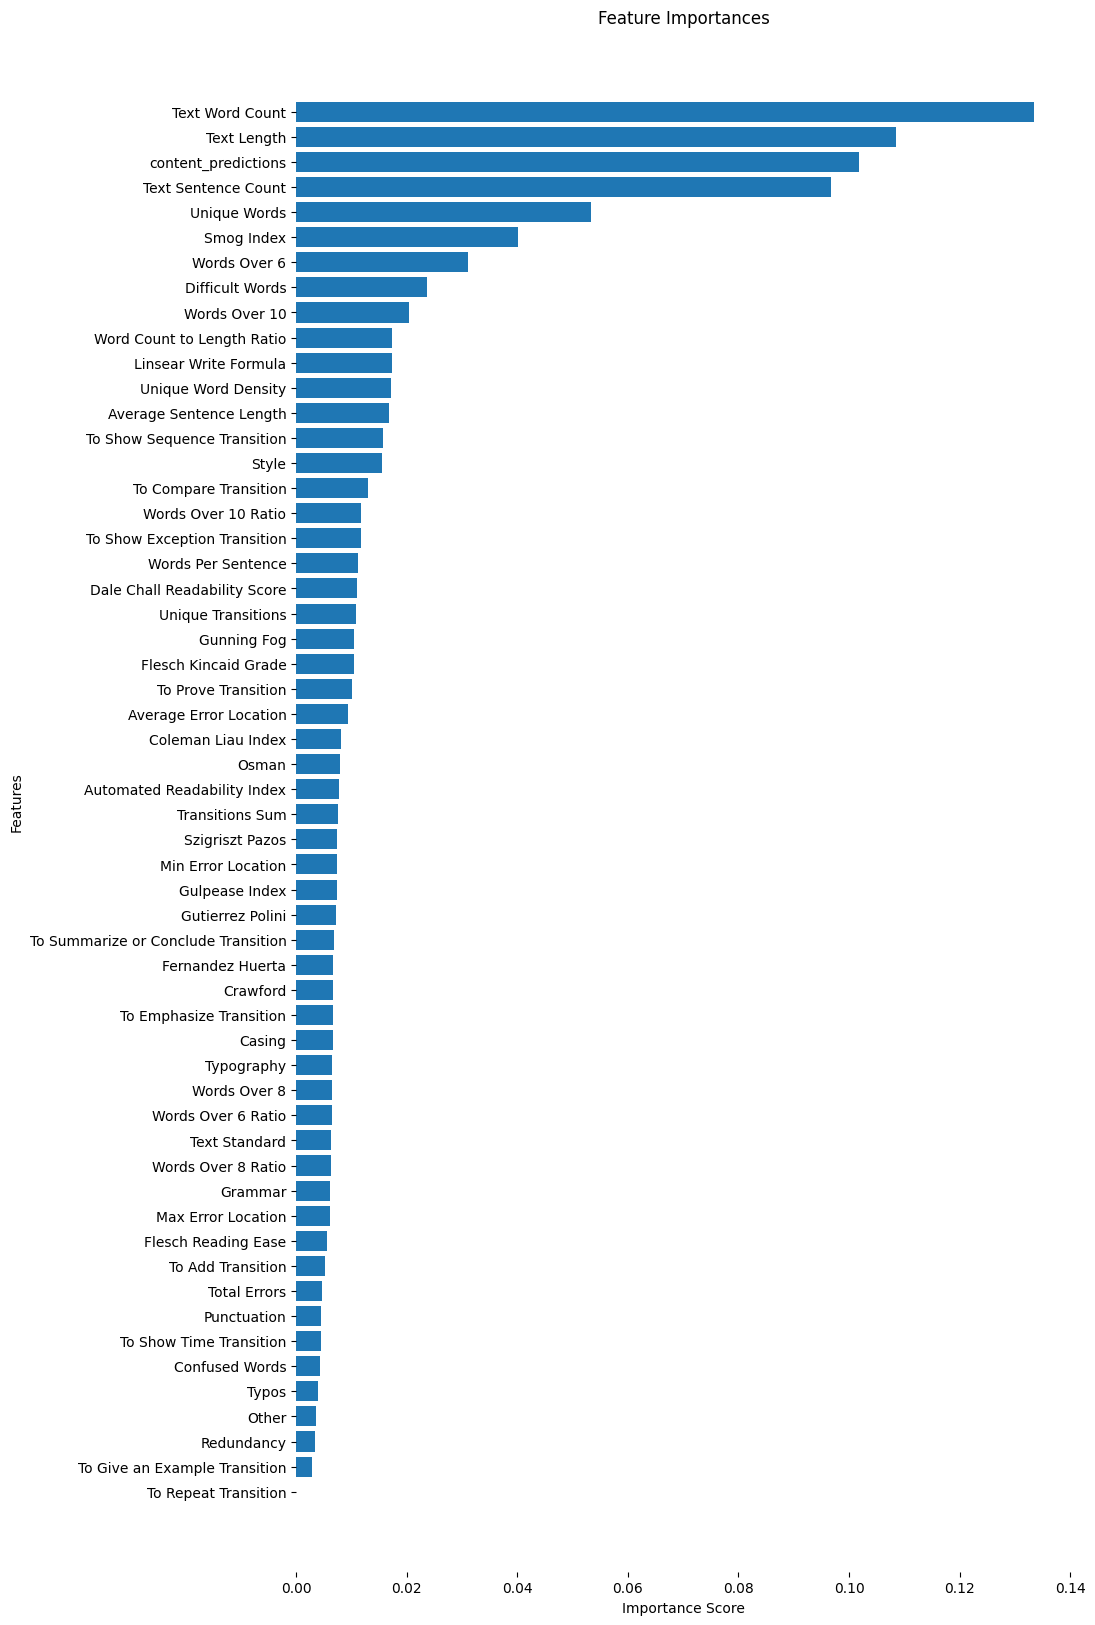

In [158]:
importances = pd.Series(model.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances')
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()